In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten,
    Conv1D, MaxPooling1D,
    LSTM, GRU
)

In [5]:
# -----------------------------
# 1) 파일 로드 함수 정의
# -----------------------------

def load_file(filepath):
    """공백(whitespace)으로 구분된 txt 파일을 읽어서 numpy 배열로 변환"""
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    """여러 센서 파일을 불러와서 (샘플, 타임스텝, 특성) 형태의 3D 배열로 결합"""
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    """train/test 그룹별로 9개 센서 신호 + 라벨 로드"""
    filepath = prefix + '/' + group + '/Inertial Signals/'

    filenames = []
    # 총가속도
    filenames += ['total_acc_x_' + group + '.txt',
                  'total_acc_y_' + group + '.txt',
                  'total_acc_z_' + group + '.txt']
    # 신체가속도
    filenames += ['body_acc_x_' + group + '.txt',
                  'body_acc_y_' + group + '.txt',
                  'body_acc_z_' + group + '.txt']
    # 자이로스코프
    filenames += ['body_gyro_x_' + group + '.txt',
                  'body_gyro_y_' + group + '.txt',
                  'body_gyro_z_' + group + '.txt']

    X = load_group(filenames, filepath)
    y = load_file(prefix + '/' + group + '/y_' + group + '.txt')
    return X, y

def load_dataset(prefix=''):
    """전체 train / test 데이터셋 로드 + 원-핫 인코딩"""
    base_path = prefix + '/content/drive/MyDrive/ml-programming-lab/week10/UCI HAR Dataset'

    trainX, trainy = load_dataset_group('train', base_path)
    testX, testy = load_dataset_group('test', base_path)

    # 라벨을 0 ~ 5로 맞추기 (원래 1~6)
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print("trainX:", trainX.shape,
          "trainy:", trainy.shape,
          "trainy_one_hot:", trainy_one_hot.shape)
    print("testX:", testX.shape,
          "testy:", testy.shape,
          "testy_one_hot:", testy_one_hot.shape)

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
# -----------------------------
# 2) 데이터셋 로드 & train/val 분리
# -----------------------------

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(prefix='')

# 80% train / 20% val
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

/tmp/ipython-input-1679697376.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1679697376.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1679697376.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1679697376.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


trainX: (7352, 128, 9) trainy: (7352, 1) trainy_one_hot: (7352, 6)
testX: (2947, 128, 9) testy: (2947, 1) testy_one_hot: (2947, 6)
X_train: (5881, 128, 9)
X_val: (1471, 128, 9)


In [7]:
# -----------------------------
# 3) 입력 차원 및 클래스 개수 설정
# -----------------------------

n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]
n_outputs   = y_train_one_hot.shape[1]

print("n_timesteps:", n_timesteps)
print("n_features :", n_features)
print("n_outputs  :", n_outputs)

n_timesteps: 128
n_features : 9
n_outputs  : 6


In [8]:
# -----------------------------
# 4) Simple CNN
# -----------------------------

simple_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

simple_cnn.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

simple_cnn.summary()

history_simple_cnn = simple_cnn.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       396,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,650 (1.57 MB)

 Trainable params: 411,650 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7038 - loss: 0.7289 - val_accuracy: 0.9239 - val_loss: 0.2224
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9327 - loss: 0.1800 - val_accuracy: 0.9368 - val_loss: 0.1516
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9524 - loss: 0.1226 - val_accuracy: 0.9443 - val_loss: 0.1550
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9550 - loss: 0.1038 - val_accuracy: 0.9456 - val_loss: 0.1256
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9564 - loss: 0.1033 - val_accuracy: 0.9504 - val_loss: 0.1329
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9577 - loss: 0.0964 - val_accuracy: 0.9504 - val_loss: 0.1152
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9599 - loss: 0.0975 - val_accuracy: 0.9137 - val_loss: 0.1785
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9506 - loss: 0.1201 - val_accuracy: 0

In [9]:
# -----------------------------
# 5) LSTM
# -----------------------------

lstm_model = Sequential([
    LSTM(128, input_shape=(n_timesteps, n_features)),
    Dense(64, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,302 (309.77 KB)

 Trainable params: 79,302 (309.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4291 - loss: 1.3710 - val_accuracy: 0.4663 - val_loss: 1.2107
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5347 - loss: 1.0894 - val_accuracy: 0.6676 - val_loss: 0.8412
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7238 - loss: 0.6677 - val_accuracy: 0.8504 - val_loss: 0.3966
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8736 - loss: 0.3517 - val_accuracy: 0.8695 - val_loss: 0.3395
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9111 - loss: 0.2618 - val_accuracy: 0.9436 - val_loss: 0.1732
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9383 - loss: 0.1834 - val_accuracy: 0.9191 - val_loss: 0.1946
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9298 - loss: 0.1900 - val_accuracy: 0.9313 - val_loss: 0.1500
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9484 - loss: 0.1271 - val_accurac

In [10]:
# -----------------------------
# 6) GRU
# -----------------------------

gru_model = Sequential([
    GRU(128, input_shape=(n_timesteps, n_features)),
    Dense(64, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

gru_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

gru_model.summary()

history_gru = gru_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,022 (242.27 KB)

 Trainable params: 62,022 (242.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4960 - loss: 1.2855 - val_accuracy: 0.7213 - val_loss: 0.6715
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7367 - loss: 0.6187 - val_accuracy: 0.8341 - val_loss: 0.4445
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8787 - loss: 0.3338 - val_accuracy: 0.9157 - val_loss: 0.2392
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9316 - loss: 0.1867 - val_accuracy: 0.9225 - val_loss: 0.1729
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9400 - loss: 0.1469 - val_accuracy: 0.9429 - val_loss: 0.1467
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9442 - loss: 0.1349 - val_accuracy: 0.9395 - val_loss: 0.1493
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9485 - loss: 0.1287 - val_accuracy: 0.9307 - val_loss: 0.1570
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9512 - loss: 0.1271 - val_accuracy:

In [11]:
# -----------------------------
# 7) CNN + LSTM
# -----------------------------

cnn_lstm_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

cnn_lstm_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

cnn_lstm_model.summary()

history_cnn_lstm = cnn_lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,606 (475.02 KB)

 Trainable params: 121,606 (475.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5832 - loss: 0.9649 - val_accuracy: 0.8097 - val_loss: 0.4749
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8092 - loss: 0.4430 - val_accuracy: 0.8457 - val_loss: 0.3819
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9012 - loss: 0.2813 - val_accuracy: 0.9211 - val_loss: 0.2273
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9344 - loss: 0.1703 - val_accuracy: 0.9368 - val_loss: 0.1585
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9411 - loss: 0.1430 - val_accuracy: 0.9463 - val_loss: 0.1300
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9522 - loss: 0.1214 - val_accuracy: 0.9436 - val_loss: 0.1295
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9307 - loss: 0.1686 - val_accuracy: 0.9375 - val_loss: 0.1412
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9478 - loss: 0.1374 - val_accuracy:

In [12]:
# -----------------------------
# 8) CNN + GRU
# -----------------------------

cnn_gru_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GRU(128),
    Dense(64, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

cnn_gru_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

cnn_gru_model.summary()

history_cnn_gru = cnn_gru_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,286 (380.02 KB)

 Trainable params: 97,286 (380.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6127 - loss: 1.0252 - val_accuracy: 0.8851 - val_loss: 0.2953
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9245 - loss: 0.2036 - val_accuracy: 0.9239 - val_loss: 0.1758
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9381 - loss: 0.1506 - val_accuracy: 0.9279 - val_loss: 0.1540
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9399 - loss: 0.1411 - val_accuracy: 0.9449 - val_loss: 0.1346
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9503 - loss: 0.1206 - val_accuracy: 0.9490 - val_loss: 0.1271
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9515 - loss: 0.1180 - val_accuracy: 0.9368 - val_loss: 0.1442
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9444 - loss: 0.1289 - val_accuracy: 0.9477 - val_loss: 0.1250
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9548 - loss: 0.1081 - val_accuracy:

In [13]:
# -----------------------------
# 9) 학습 곡선 함수 & 평가 함수
# -----------------------------

def plot_history(history, title_prefix="Model"):
    """loss / accuracy 학습 곡선 출력"""
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    epochs = range(1, len(loss) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, loss, 'y', label='Training loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title_prefix} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    if acc is not None:
        plt.figure()
        plt.plot(epochs, acc, 'y', label='Training acc')
        if val_acc is not None:
            plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title(f'{title_prefix} - Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

def evaluate_on_test(model, testX, testy, model_name="Model"):
    """테스트 데이터로 정확도, 혼동행렬, 리포트 출력"""
    # testy가 (N,1) 형태면 1차원으로 펼치기
    y_true = testy.flatten()

    probs = model.predict(testX)
    y_pred = np.argmax(probs, axis=-1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    print(f"\n========== {model_name} - Test Evaluation ==========")
    print("Confusion Matrix:\n", cm)
    print("\nAccuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    plt.figure()
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

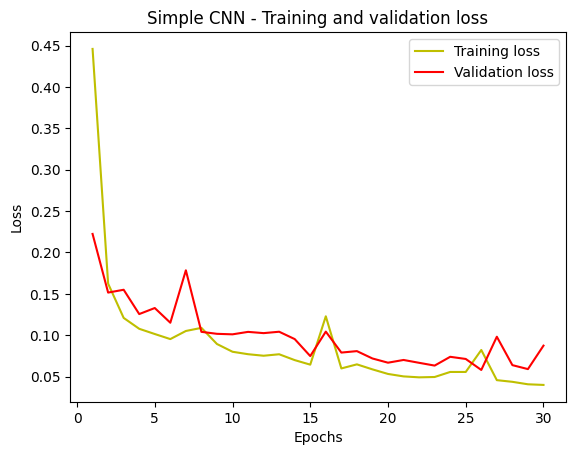

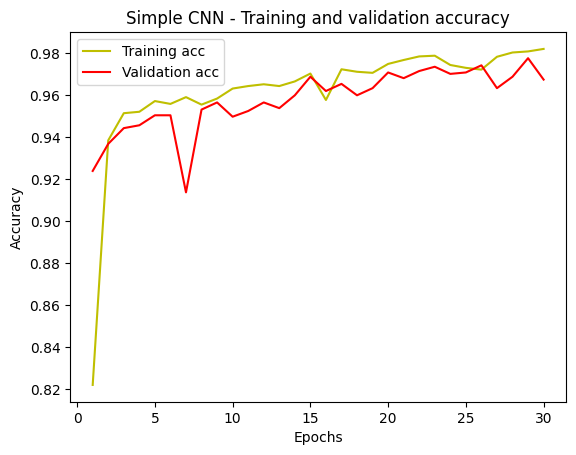

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

========== Simple CNN - Test Evaluation ==========
Confusion Matrix:
 [[457  21  18   0   0   0]
 [ 10 443  18   0   0   0]
 [  6  41 373   0   0   0]
 [  0   8   0 406  74   3]
 [  1   2   0  58 471   0]
 [  0  27   0   0   0 510]]

Accuracy: 0.9026128266033254

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       496
           1       0.82      0.94      0.87       471
           2       0.91      0.89      0.90       420
           3       0.88      0.83      0.85       491
           4       0.86      0.89      0.87       532
           5       0.99      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947



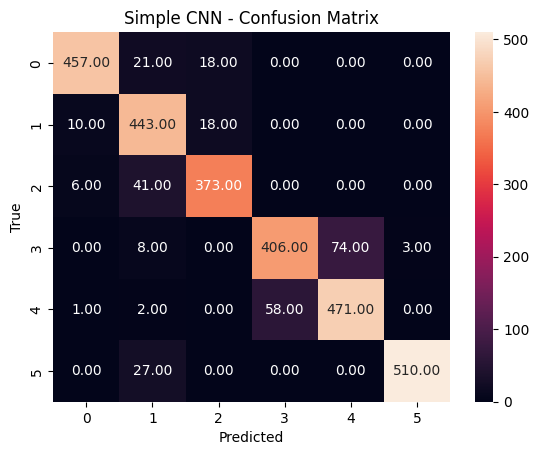

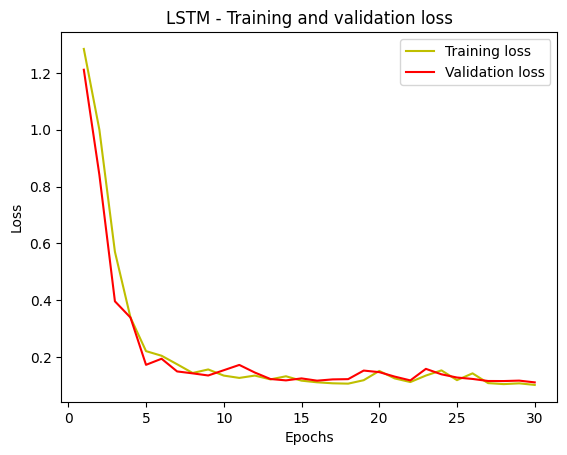

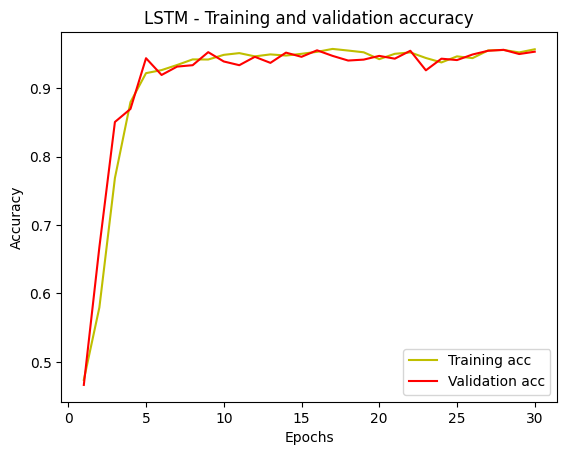

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

========== LSTM - Test Evaluation ==========
Confusion Matrix:
 [[477  18   1   0   0   0]
 [  5 466   0   0   0   0]
 [  2   8 410   0   0   0]
 [  0   3   0 416  72   0]
 [  0   1   0 103 428   0]
 [  0  16   0   0   0 521]]

Accuracy: 0.9222938581608415

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       496
           1       0.91      0.99      0.95       471
           2       1.00      0.98      0.99       420
           3       0.80      0.85      0.82       491
           4       0.86      0.80      0.83       532
           5       1.00      0.97      0.98       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



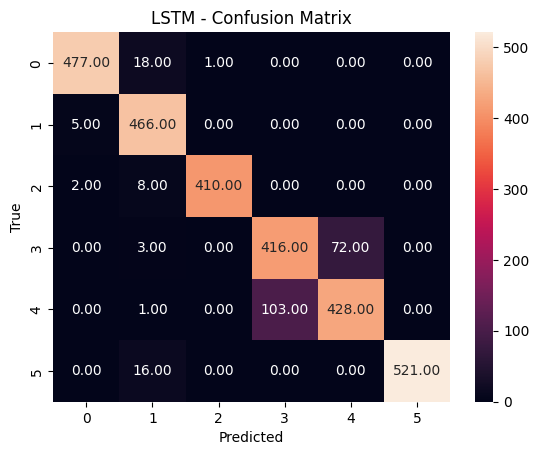

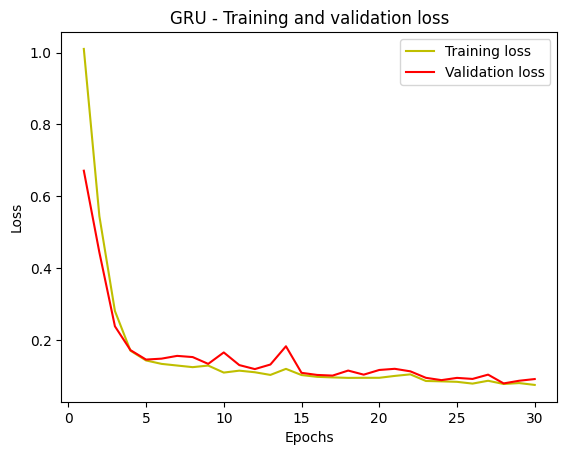

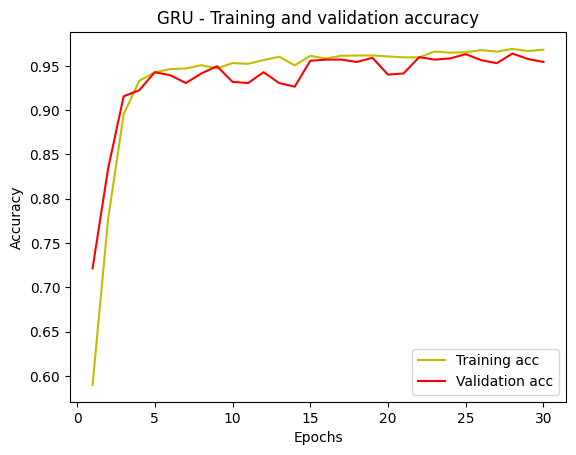

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

========== GRU - Test Evaluation ==========
Confusion Matrix:
 [[460  10  26   0   0   0]
 [  5 449  17   0   0   0]
 [  0   8 412   0   0   0]
 [  0   4   0 315 172   0]
 [  0   3   0  13 516   0]
 [  0  27   0   0   0 510]]

Accuracy: 0.9032914828639295

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       496
           1       0.90      0.95      0.92       471
           2       0.91      0.98      0.94       420
           3       0.96      0.64      0.77       491
           4       0.75      0.97      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.92      0.90      0.90      2947
weighted avg       0.92      0.90      0.90      2947



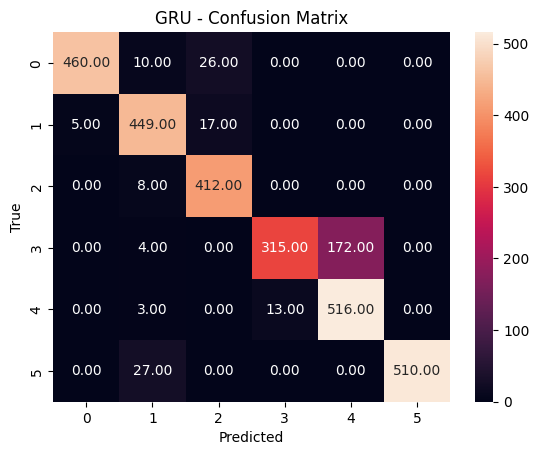

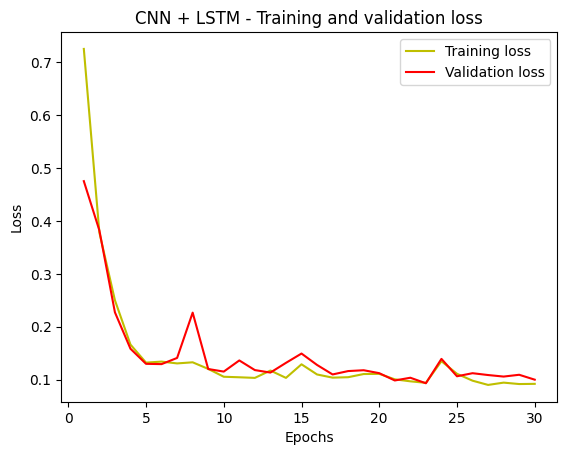

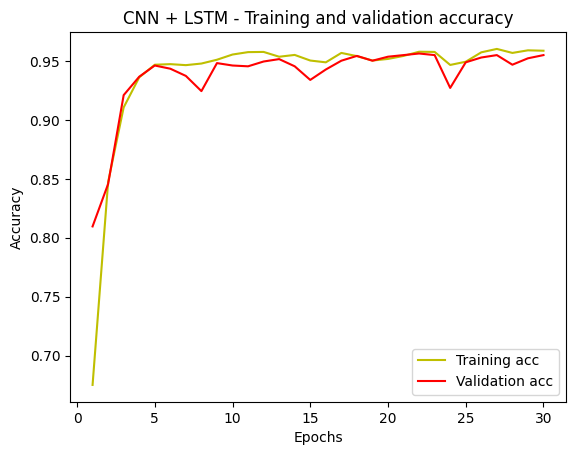

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

========== CNN + LSTM - Test Evaluation ==========
Confusion Matrix:
 [[489   5   2   0   0   0]
 [  6 451  14   0   0   0]
 [  5   6 409   0   0   0]
 [  0  19   0 410  57   5]
 [  0   3   0  96 433   0]
 [  0  22   0   0   0 515]]

Accuracy: 0.9185612487275195

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       496
           1       0.89      0.96      0.92       471
           2       0.96      0.97      0.97       420
           3       0.81      0.84      0.82       491
           4       0.88      0.81      0.85       532
           5       0.99      0.96      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



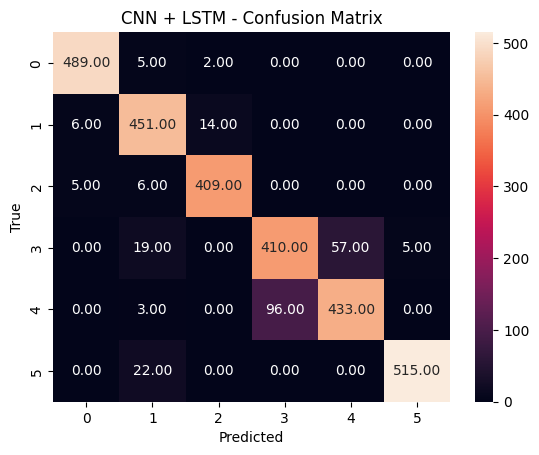

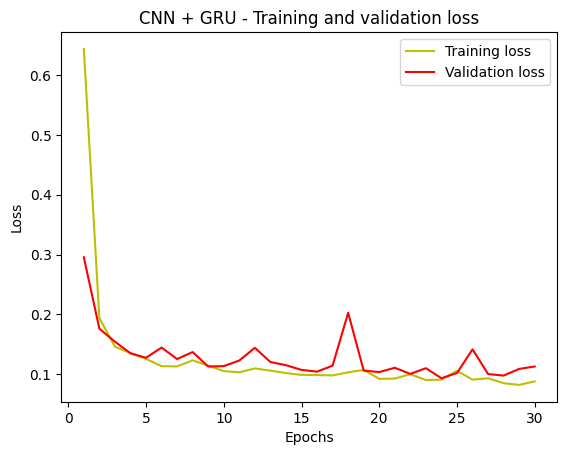

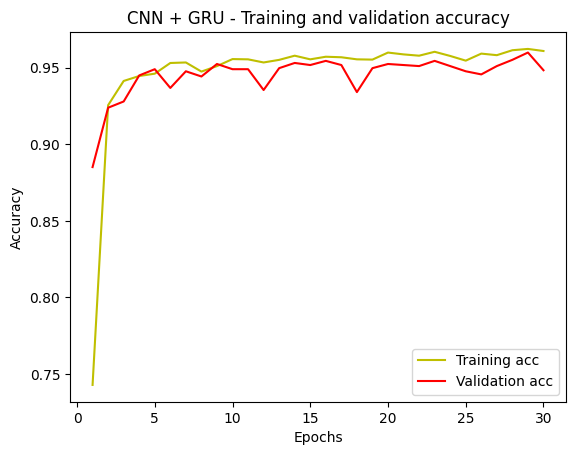

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

========== CNN + GRU - Test Evaluation ==========
Confusion Matrix:
 [[493   2   1   0   0   0]
 [ 31 431   9   0   0   0]
 [  8   2 410   0   0   0]
 [  0   6   0 430  54   1]
 [  0   0   0 104 428   0]
 [  0  27   0   0   0 510]]

Accuracy: 0.9168646080760094

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       496
           1       0.92      0.92      0.92       471
           2       0.98      0.98      0.98       420
           3       0.81      0.88      0.84       491
           4       0.89      0.80      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



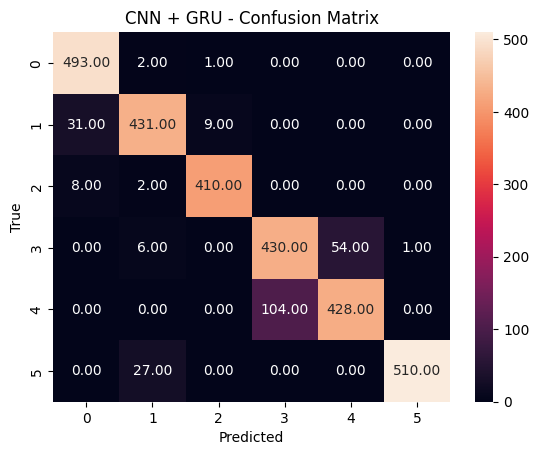

In [14]:
# -----------------------------
# 10) 학습 곡선 & 테스트 평가
# -----------------------------

plot_history(history_simple_cnn, title_prefix="Simple CNN")
evaluate_on_test(simple_cnn, testX, testy, model_name="Simple CNN")

plot_history(history_lstm, title_prefix="LSTM")
evaluate_on_test(lstm_model, testX, testy, model_name="LSTM")

plot_history(history_gru, title_prefix="GRU")
evaluate_on_test(gru_model, testX, testy, model_name="GRU")

plot_history(history_cnn_lstm, title_prefix="CNN + LSTM")
evaluate_on_test(cnn_lstm_model, testX, testy, model_name="CNN + LSTM")

plot_history(history_cnn_gru, title_prefix="CNN + GRU")
evaluate_on_test(cnn_gru_model, testX, testy, model_name="CNN + GRU")